In [1]:
import torch
import torch.nn as nn
from torch.nn.utils.parametrizations import spectral_norm
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import os
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, path):

        self.data = np.load(path, mmap_mode='r')

    def __getitem__(self, idx):

        image = self.data[idx]
        image = (image+1.0)*0.5
        image = image*255.0
        image = image.astype('uint8')
        pic = Image.fromarray(image)
        pic4x4 = pic.resize((4,4))
        pic8x8 = pic.resize((8,8))
        pic16x16 = pic.resize((16,16))
        pic32x32 = pic.resize((32,32))

        image4x4 = np.array(pic4x4, dtype=np.float32)
        image8x8 = np.array(pic8x8, dtype=np.float32)
        image16x16 = np.array(pic16x16, dtype=np.float32)
        image32x32 = np.array(pic32x32, dtype=np.float32)
        pic.close()
        del pic4x4, pic8x8, pic16x16, pic32x32

        image4x4 = image4x4/127.5 - 1.0
        image4x4 = torch.from_numpy(image4x4)
        image4x4 = image4x4.view(image4x4.size(2), image4x4.size(0), image4x4.size(1))
        
        image8x8 = image8x8/127.5 - 1.0
        image8x8 = torch.from_numpy(image8x8)
        image8x8 = image8x8.view(image8x8.size(2), image8x8.size(0), image8x8.size(1))

        image16x16 = image16x16/127.5 - 1.0
        image16x16 = torch.from_numpy(image16x16)
        image16x16 = image16x16.view(image16x16.size(2), image16x16.size(0), image16x16.size(1))

        image32x32 = image32x32/127.5 - 1.0
        image32x32 = torch.from_numpy(image32x32)
        image32x32 = image32x32.view(image32x32.size(2), image32x32.size(0), image32x32.size(1))

        return image4x4, image8x8, image16x16, image32x32

    def __len__(self):

        return len(self.data)

In [4]:
data = Dataset('D:/Python/Projects/Datasets/Complete_dataset.npy')

In [5]:
class GenResidualBlock(nn.Module):

    '''
    No use of BatchNorm in the generator in order to avoid random noise in the outputs.
    See ESRGAN paper for further details.
    '''

    def __init__(self, channels, kernel=3, stride=1, padding=1):

        super(GenResidualBlock, self).__init__()

        self.convA = nn.Conv2d(channels, channels, kernel, stride, padding, bias=False)
        self.convB = nn.Conv2d(channels, channels, kernel, stride, padding, bias=False)
        self.convC = nn.Conv2d(channels, channels, kernel, stride, padding, bias=False)

        self.PRelu = nn.PReLU()
        
    def forward(self, input):

        r1 = input

        x = self.convA(input)
        r2 = self.PRelu(x)

        x = r2 + r1

        x = self.convB(x)
        r3 = self.PRelu(x)

        x = r3 + r2 + r1

        x = self.convC(x)
        
        output = x + r3 + r2 + r1

        del r1, r2, r3, x

        return output

In [6]:
class Generator(nn.Module):
    '''
    Using Residual Blocks
    '''


    def __init__(self, ):

        super(Generator, self).__init__()

        self.transconv1 = nn.ConvTranspose2d(1024, 128, 4, 1, 0, bias=False)
        self.resblock1 = GenResidualBlock(128, 3, 1, 1)
        self.conv1 = nn.Conv2d(128, 3, 1, 1, bias=False)
        self.resblock2 = GenResidualBlock(128, 3, 1, 1)
        self.conv2 = nn.Conv2d(128, 3, 1, 1, bias=False)
        self.resblock3 = GenResidualBlock(128, 3, 1, 1)
        self.conv3 = nn.Conv2d(128, 3, 1, 1, bias=False)
        self.resblock4 = GenResidualBlock(128, 3, 1, 1)
        self.conv5 = nn.Conv2d(128, 3, 3, 1, 1, bias=False)
        self.resblock5 = GenResidualBlock(3, 3, 1, 1)

        # Possibilidade: Usar Linear + LogSoftmax para selecionar os canais que formam a melhor imagem
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.tanh = nn.Tanh() # Since our images are between -1 and 1. Consider removing if having problems with vanishing gradients.

    def forward(self, input):

        x = self.transconv1(input)
        x = self.resblock1(x)

        output1 = self.conv1(x)
        output1 = self.tanh(output1)

        x = self.upsample(x)
        x = self.resblock2(x)

        output2 = self.conv2(x)
        output2 = self.tanh(output2)

        x = self.upsample(x)
        x = self.resblock3(x)

        output3 = self.conv3(x)
        output3 = self.tanh(output3)

        x = self.upsample(x)
        x = self.resblock4(x)

        #x = self.upsample(x)
        x = self.conv5(x)
        x = self.resblock5(x)

        output = self.tanh(x)

        del x

        return output1, output2, output3, output

In [7]:
netG = Generator().to(device)

In [8]:
class Discriminator4x4(nn.Module):
    def __init__(self):
        super(Discriminator4x4, self).__init__()

        self.conv1A = nn.Conv2d(3, 128, 3, 1, 1, bias=False)
        self.neuron_out = nn.Linear(4*4*128, 1, bias=True)

        self.LRelu = nn.LeakyReLU(0.2)
    
    def forward(self, input):

        x = self.conv1A(input)
        features = self.LRelu(x)

        x = features.view(features.size(0), -1)

        output = self.neuron_out(x)

        return output, features

In [9]:
class Discriminator8x8(nn.Module):
    def __init__(self):
        super(Discriminator8x8, self).__init__()

        self.conv1A = nn.Conv2d(3, 128, 3, 1, 1, bias=False)
        self.conv2A = nn.Conv2d(128, 256, 4, 2, 1, bias=False)
        self.conv2B = nn.Conv2d(256, 256, 3, 1, 1, bias=False)
        self.batchnorm2B = nn.BatchNorm2d(256)
        self.conv2C = nn.Conv2d(256, 256, 3, 1, 1, bias=False)
        self.batchnorm2C = nn.BatchNorm2d(256)
        self.neuron_out = nn.Linear(4*4*256, 1, bias=True)

        self.LRelu = nn.LeakyReLU(0.2)
    
    def forward(self, input):

        x = self.conv1A(input)
        x = self.LRelu(x)

        x = self.conv2A(x)
        x = self.LRelu(x)
        x = self.conv2B(x)
        x = self.batchnorm2B(x)
        x = self.LRelu(x)
        x = self.conv2C(x)
        x = self.batchnorm2C(x)
        features = self.LRelu(x)

        x = features.view(features.size(0), -1)

        output = self.neuron_out(x)

        #output = self.sigmoid(x)

        return output, features

In [10]:
class Discriminator16x16(nn.Module):
    def __init__(self):
        super(Discriminator16x16, self).__init__()

        self.conv1A = nn.Conv2d(3, 128, 3, 1, 1, bias=False)
        #self.conv1B = nn.Conv2d(200, 200, 3, 1, 1, bias=True)
        self.conv2A = nn.Conv2d(128, 256, 4, 2, 1, bias=False)
        self.conv2B = nn.Conv2d(256, 256, 3, 1, 1, bias=False)
        self.batchnorm2B = nn.BatchNorm2d(256)
        self.conv2C = nn.Conv2d(256, 256, 3, 1, 1, bias=False)
        self.batchnorm2C = nn.BatchNorm2d(256)
        self.conv3A = nn.Conv2d(256, 512, 4, 2, 1, bias=False)
        self.conv3B = nn.Conv2d(512, 512, 3, 1, 1, bias=False)
        self.batchnorm3B = nn.BatchNorm2d(512)
        self.conv3C = nn.Conv2d(512, 512, 3, 1, 1, bias=False)
        self.batchnorm3C = nn.BatchNorm2d(512)
        self.neuron_out = nn.Linear(4*4*512, 1, bias=True)

        self.LRelu = nn.LeakyReLU(0.2)
    
    def forward(self, input):

        x = self.conv1A(input)
        x = self.LRelu(x)

        x = self.conv2A(x)
        x = self.LRelu(x)
        x = self.conv2B(x)
        x = self.batchnorm2B(x)
        x = self.LRelu(x)
        x = self.conv2C(x)
        x = self.batchnorm2C(x)
        x = self.LRelu(x)

        x = self.conv3A(x)
        x = self.LRelu(x)
        x = self.conv3B(x)
        x = self.batchnorm3B(x)
        x = self.LRelu(x)
        x = self.conv3C(x)
        x = self.batchnorm3C(x)
        features = self.LRelu(x)

        x = features.view(features.size(0), -1)

        output = self.neuron_out(x)

        #output = self.sigmoid(x)

        return output, features

In [11]:
class Discriminator32x32(nn.Module):
    def __init__(self):
        super(Discriminator32x32, self).__init__()

        self.conv1A = nn.Conv2d(3, 128, 3, 1, 1, bias=False)
        self.conv2A = nn.Conv2d(128, 256, 4, 2, 1, bias=False)
        self.conv2B = nn.Conv2d(256, 256, 3, 1, 1, bias=False)
        self.batchnorm2B = nn.BatchNorm2d(256)
        self.conv2C = nn.Conv2d(256, 256, 3, 1, 1, bias=False)
        self.batchnorm2C = nn.BatchNorm2d(256)
        self.conv3A = nn.Conv2d(256, 512, 4, 2, 1, bias=False)
        self.conv3B = nn.Conv2d(512, 512, 3, 1, 1, bias=False)
        self.batchnorm3B = nn.BatchNorm2d(512)
        self.conv3C = nn.Conv2d(512, 512, 3, 1, 1, bias=False)
        self.batchnorm3C = nn.BatchNorm2d(512)
        self.conv4A = nn.Conv2d(512, 1024, 4, 2, 1, bias=False)
        self.conv4B = nn.Conv2d(1024, 1024, 3, 1, 1, bias=False)
        self.batchnorm4B = nn.BatchNorm2d(1024)
        self.conv4C = nn.Conv2d(1024, 1024, 3, 1, 1, bias=False)
        self.batchnorm4C = nn.BatchNorm2d(1024)
        self.neuron_out = nn.Linear(4*4*1024, 1, bias=True)

        self.LRelu = nn.LeakyReLU(0.2)
    
    def forward(self, input):

        x = self.conv1A(input)
        x = self.LRelu(x)

        x = self.conv2A(x)
        x = self.LRelu(x)
        x = self.conv2B(x)
        x = self.batchnorm2B(x)
        x = self.LRelu(x)
        x = self.conv2C(x)
        x = self.batchnorm2C(x)
        x = self.LRelu(x)

        x = self.conv3A(x)
        x = self.LRelu(x)
        x = self.conv3B(x)
        x = self.batchnorm3B(x)
        x = self.LRelu(x)
        x = self.conv3C(x)
        x = self.batchnorm3C(x)
        x = self.LRelu(x)

        x = self.conv4A(x)
        x = self.LRelu(x)
        x = self.conv4B(x)
        x = self.batchnorm4B(x)
        x = self.LRelu(x)
        x = self.conv4C(x)
        x = self.batchnorm4C(x)
        features = self.LRelu(x)

        x = features.view(features.size(0), -1)

        output = self.neuron_out(x)

        return output, features

In [12]:
netD1 = Discriminator4x4().to(device)
netD2 = Discriminator8x8().to(device)
netD3 = Discriminator16x16().to(device)
netD4 = Discriminator32x32().to(device)

In [13]:
def weights_init(net):
    '''
    Using weights values that are too low can lead to vanishing gradients.
    But it might be necessary in some architectures. See ESRGAN paper for further details
    '''

    for n, p in net.named_parameters():

        if 'conv' and 'weight' in n:

            #nn.init.normal_(p, 0, 0.2/p.size(0))
            nn.init.normal_(p, 0, 0.02)

        elif 'conv' and 'bias' in n:

            nn.init.constant_(p, 0.)

        elif 'neuron' and 'weight' in n:

            #nn.init.normal_(p, 0, 0.2/p.size(0))
            nn.init.normal_(p, 0, 0.02)

        elif 'neuron' and 'bias' in n:

            nn.init.constant_(p, 0.)

        elif 'batchnorm' and 'weight' in n:
            nn.init.normal_(p, 1, 0.02)

        elif 'batchnorm' and 'bias' in n:
            nn.init.constant_(p, 0.)

In [14]:
weights_init(netG)
weights_init(netD1)
weights_init(netD2)
weights_init(netD3)
weights_init(netD4)

In [15]:
optimizerD1 = optim.Adam(netD1.parameters(), lr=1e-4, betas=(0., 0.999))
optimizerD2 = optim.Adam(netD2.parameters(), lr=1e-4, betas=(0., 0.999))
optimizerD3 = optim.Adam(netD3.parameters(), lr=1e-4, betas=(0., 0.999))
optimizerD4 = optim.Adam(netD4.parameters(), lr=1e-4, betas=(0., 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=1e-4, betas=(0., 0.999))

In [18]:
# Dueling Discriminators might be of big help when facing instability issues

netDI = Discriminator4x4().to(device)
netDII = Discriminator8x8().to(device)
netDIII = Discriminator16x16().to(device)
netDIV = Discriminator32x32().to(device)

optimizerDI = optim.Adam(netDI.parameters(), lr=1e-4, betas=(0., 0.999))
optimizerDII = optim.Adam(netDII.parameters(), lr=1e-4, betas=(0., 0.999))
optimizerDIII = optim.Adam(netDIII.parameters(), lr=1e-4, betas=(0., 0.999))
optimizerDIV = optim.Adam(netDIV.parameters(), lr=1e-4, betas=(0., 0.999))

In [ ]:
weights_init(netDI)
weights_init(netDII)
weights_init(netDIII)
weights_init(netDIV)

In [16]:
def to_numpy(tensor):

    tensor = tensor.view(tensor.size(0), tensor.size(2), tensor.size(3), tensor.size(1))
    tensor = tensor.detach().cpu().numpy()
    tensor = (tensor+1.0)*0.5
    
    return tensor

In [17]:
dataloader = torch.utils.data.DataLoader(data, batch_size=16, shuffle=True, drop_last=True)

bce = nn.BCELoss()
sigmoid = nn.Sigmoid() # Sigmoid without Logits
mse = nn.MSELoss()

start_epoch = 0
EPOCHS = 100

In [18]:
# When using Dueling Discriminators, remember to also save parameters for the counterpart discriminators.
params = torch.load("D:/Python/Projects/GANs/Cocogoat/Prototype_Cocogoat.tar")

netD1.load_state_dict(params['discriminator1_params'])
netD2.load_state_dict(params['discriminator2_params'])
netD3.load_state_dict(params['discriminator3_params'])
netD4.load_state_dict(params['discriminator4_params'])
netG.load_state_dict(params['generator_params'])
start_epoch = params['epoch']

In [21]:
print(data.data.shape)

(45935, 100, 100, 3)


14|100
Discriminators Loss: 3.3302664756774902
Gradients Average:
	Discriminator 1: 0.00443496648222208	Discriminator 2: -0.26172342896461487	Discriminator 3: -0.09961031377315521	Discriminator 4: -2.0361949282232672e-05
Real Output Mean: 338.74951171875	Fake Output Mean: 324.5635070800781
Generator Loss: 60.98929977416992	Gradients Average: -5.768596020061523e-05
Adversarial Loss: 60.98926544189453	Content Loss: 0.03569215163588524


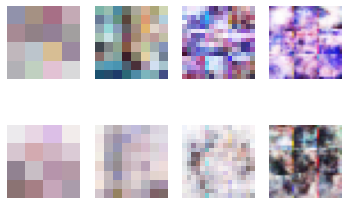

KeyboardInterrupt: 

In [19]:
for epoch in range(start_epoch, EPOCHS):

    for i, (image4x4, image8x8, image16x16, image32x32) in enumerate(dataloader):

        image4x4, image8x8, image16x16, image32x32 = image4x4.to(device), image8x8.to(device), image16x16.to(device), image32x32.to(device)

        real_label = torch.full((image4x4.size(0), 1), 1, dtype=torch.float, device=device)
        fake_label = torch.full((image4x4.size(0), 1), 0, dtype=torch.float, device=device)

        netD1.zero_grad()
        netD2.zero_grad()
        netD3.zero_grad()
        netD4.zero_grad()

        real_output1, _ = netD1(image4x4)
        real_mean1 = torch.mean(real_output1.detach())
        real_output2, _ = netD2(image8x8)
        real_mean2 = torch.mean(real_output2.detach())
        real_output3, _ = netD3(image16x16)
        real_mean3 = torch.mean(real_output3.detach())
        real_output4, _ = netD4(image32x32)
        real_mean4 = torch.mean(real_output4.detach())

        noise = torch.randn((image4x4.size(0), 1024, 1, 1), device=device)

        out1, out2, out3, out4 = netG(noise)

        fake_output1, _ = netD1(out1)
        fake_mean1 = torch.mean(fake_output1.detach())
        fake_output2, _ = netD2(out2)
        fake_mean2 = torch.mean(fake_output2.detach())
        fake_output3, _ = netD3(out3)
        fake_mean3 = torch.mean(fake_output3.detach())
        fake_output4, _ = netD4(out4)
        fake_mean4 = torch.mean(fake_output4.detach())

        real_output1 = sigmoid(real_output1 - fake_mean1)
        real_output2 = sigmoid(real_output2 - fake_mean2)
        real_output3 = sigmoid(real_output3 - fake_mean3)
        real_output4 = sigmoid(real_output4 - fake_mean4)

        fake_output1 = sigmoid(fake_output1 - real_mean1)
        fake_output2 = sigmoid(fake_output2 - real_mean2)
        fake_output3 = sigmoid(fake_output3 - real_mean3)
        fake_output4 = sigmoid(fake_output4 - real_mean4)

        real_loss = bce(real_output1, real_label) + bce(real_output2, real_label) + bce(real_output3, real_label) + bce(real_output4, real_label)
        fake_loss = bce(fake_output1, fake_label) + bce(fake_output2, fake_label) + bce(fake_output3, fake_label) + bce(fake_output4, fake_label)

        discriminator_loss = real_loss + fake_loss

        discriminator_loss.backward()

        D1grads = torch.mean(netD1.conv1A.weight.grad)
        D2grads = torch.mean(netD2.conv1A.weight.grad)
        D3grads = torch.mean(netD3.conv1A.weight.grad)
        D4grads = torch.mean(netD4.conv1A.weight.grad)

        optimizerD1.step()
        optimizerD2.step()
        optimizerD3.step()
        optimizerD4.step()


        netG.zero_grad()

        real_output1, features_real1 = netD1(image4x4)
        real_mean1 = torch.mean(real_output1.detach())
        real_output2, features_real2 = netD2(image8x8)
        real_mean2 = torch.mean(real_output2.detach())
        real_output3, features_real3 = netD3(image16x16)
        real_mean3 = torch.mean(real_output3.detach())
        real_output4, features_real4 = netD4(image32x32)
        real_mean4 = torch.mean(real_output4.detach())

        noise = torch.randn((image4x4.size(0), 1024, 1, 1), device=device)

        out1, out2, out3, out4 = netG(noise)

        fake_output1, features_fake1 = netD1(out1)
        fake_mean1 = torch.mean(fake_output1.detach())
        fake_output2, features_fake2 = netD2(out2)
        fake_mean2 = torch.mean(fake_output2.detach())
        fake_output3, features_fake3 = netD3(out3)
        fake_mean3 = torch.mean(fake_output3.detach())
        fake_output4, features_fake4 = netD4(out4)
        fake_mean4 = torch.mean(fake_output4.detach())

        real_output1 = sigmoid(real_output1 - fake_mean1)
        real_output2 = sigmoid(real_output2 - fake_mean2)
        real_output3 = sigmoid(real_output3 - fake_mean3)
        real_output4 = sigmoid(real_output4 - fake_mean4)

        fake_output1 = sigmoid(fake_output1 - real_mean1)
        fake_output2 = sigmoid(fake_output2 - real_mean2)
        fake_output3 = sigmoid(fake_output3 - real_mean3)
        fake_output4 = sigmoid(fake_output4 - real_mean4)

        real_loss = bce(real_output1, fake_label) + bce(real_output2, fake_label) + bce(real_output3, fake_label) + bce(real_output4, fake_label)
        fake_loss = bce(fake_output1, real_label) + bce(fake_output2, real_label) + bce(fake_output3, real_label) + bce(fake_output4, real_label)

        adversarial_loss = real_loss + fake_loss

        content_loss = mse(features_fake1, features_real1.detach()) + mse(features_fake2, features_real2.detach()) + mse(features_fake3, features_real3.detach()) + mse(features_fake4, features_real4.detach())

        generator_loss = adversarial_loss + (content_loss * 1e-3)

        generator_loss.backward()

        Ggrads = torch.mean(netG.transconv1.weight.grad)

        optimizerG.step()

        if i % 1000 == 0:
            
            print(f"{epoch}|{EPOCHS}")
            print(f"Discriminators Loss: {discriminator_loss.item()}")
            print(f"Gradients Average:\n\tDiscriminator 1: {D1grads}\tDiscriminator 2: {D2grads}\tDiscriminator 3: {D3grads}\tDiscriminator 4: {D4grads}")
            #print(f"Adversarial Loss: {adversarial_error.item()}\tConsistency Loss: {consistency_loss.item()}")
            print(f"Real Output Mean: {real_mean4}\tFake Output Mean: {fake_mean4}")
            print(f"Generator Loss: {generator_loss.item()}\tGradients Average: {Ggrads}")
            print(f"Adversarial Loss: {adversarial_loss.item()}\tContent Loss: {content_loss.item()}")

            with torch.no_grad():

                out1, out2, out3, out4 = netG(noise)

            out1 = to_numpy(out1)
            out2 = to_numpy(out2)
            out3 = to_numpy(out3)
            out4 = to_numpy(out4)
            
            fig, ax = plt.subplots(2,4)

            for x in range(ax.shape[0]):
                for y in range(ax.shape[1]):
                    ax[x,y].axis('off')

            ax[0,0].imshow(out1[0])
            ax[1,0].imshow(out1[1])
            ax[0,1].imshow(out2[0])
            ax[1,1].imshow(out2[1])
            ax[0,2].imshow(out3[0])
            ax[1,2].imshow(out3[1])
            ax[0,3].imshow(out4[0])
            ax[1,3].imshow(out4[1])
            plt.show()

            torch.save({
                    'epoch': epoch,
                    'discriminator1_params': netD1.state_dict(),
                    'discriminator2_params': netD2.state_dict(),
                    'discriminator3_params': netD3.state_dict(),
                    'discriminator4_params': netD4.state_dict(),
                    'generator_params': netG.state_dict(),
                }, f"D:/Python/Projects/GANs/Cocogoat/Prototype_Cocogoat.tar")
